<a href="https://colab.research.google.com/github/ancestor9/MicroGPT-/blob/main/Basic_Understanding_microgpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

대형언어모델(LLM)의 복잡한 구조를 요약, 단 200줄의 순수 파이썬 코드로 GPT의 핵심 원리를 구현한 프로젝트가 공개됐다.

안드레이 카르파시가 선보인 ‘마이크로GPT(MicroGPT)’는 외부 라이브러리 없이도 GPT의 학습과 추론 과정을 모두 수행하는 단일 파일 프로그램이다.

거대한 인프라나 복잡한 프레임워크 없이, LLM이 작동하는 알고리즘의 본질만을 가장 단순한 형태로 담아냈다는 평가를 받고 있다.

카르파시 유레카랩스 CEO는 12일(현지시간) 블로그를 통해 ‘마이크로GPT’를 소개하며, 이를 하나의 “예술 작품(art project)”이라고 표현했다.

그는 GPT를 구성하는 모든 핵심 요소를 단 하나의 파일에 담았다고 설명하며, “이보다 더 단순하게 줄일 수는 없다”라고 강조했다.

마이크로GPT는 단 하나의 파이썬 파일로 구성된다. 이 파일 안에는
- ▲데이터셋 처리
- ▲토크나이저
- ▲자동 미분(autograd) 엔진
- ▲GPT-2와 유사한 신경망 구조
- ▲아담(Adam) 옵티마이저
- ▲학습 루프
- ▲추론 루프   

까지, GPT가 작동하는 전 과정이 모두 담겨 있다.

### [원문기사](https://www.aitimes.com/news/articleView.html?idxno=206917)

### 원래 코드를 7개 모듈로 분해하여 학습을 목적으로 각 모듈의 핵심을 짧게 요약하면:

1. 데이터셋 처리 — 이름 목록을 불러와 셔플. 문서 단위 학습의 기본 구조.
2. 토크나이저 — 문자 ↔ 정수 변환. BOS 특수 토큰으로 시작/끝 표시.
3. Autograd 엔진 — PyTorch 없이 스칼라 수준에서 역전파 구현. 계산 그래프 + 체인 룰의 정수.
4. GPT 신경망 — 임베딩 → RMSNorm → Multi-Head Attention → MLP → 잔차 연결의 반복. GPT-2 아키텍처의 축소판.
5. Adam 옵티마이저 — 1차/2차 모멘텀으로 파라미터별 적응적 학습률을 계산.
6. 학습 루프 — 순전파 → 크로스엔트로피 손실 → 역전파 → Adam 업데이트의 반복.
7. 추론 루프 — BOS를 시작으로 온도(temperature)에 따라 확률적으로 다음 토큰을 샘플링.

>> 특히 모듈 3(Autograd) 이 이 코드의 교육적 핵심으로 PyTorch가 내부적으로 하는 일을 50줄로 직접 구현한 것이라, 이 부분을 확실히 이해하면 딥러닝의 역전파 원리 전체가 명확해집니다.

### 모듈 1 ▲ 데이터셋 처리

In [1]:
import os       # os.path.exists
import math     # math.log, math.exp
import random   # random.seed, random.choices, random.gauss, random.shuffle

if not os.path.exists('input.txt'):
    import urllib.request
    names_url = 'https://raw.githubusercontent.com/karpathy/makemore/988aa59/names.txt'
    urllib.request.urlretrieve(names_url, 'input.txt')

docs = [line.strip() for line in open('input.txt') if line.strip()]
random.shuffle(docs)

In [2]:
print(len(docs))

32033


In [3]:
' / '.join(docs[:15])

'kedan / dalayza / terrell / rosario / lijah / keilynn / nayah / aveen / khamiyah / chicago / greer / maziyah / janai / jerico / jahaziah'

설명

- input.txt가 없으면 인터넷에서 이름 목록(약 32,000개)을 자동 다운로드합니다.
- 각 줄을 하나의 문서(document) 로 취급합니다. 여기서 문서 = 사람 이름 하나.
- random.shuffle로 순서를 섞어 학습 편향을 방지합니다.
- 핵심 개념: 언어 모델은 문서 단위로 학습합니다. 문서가 짧은 이름이든 긴 소설이든 원리는 동일합니다.



In [4]:
# 메모리 절약을 위해 3200개 단어만 사용

docs = docs[:3200]
print(f"Extracted {len(docs)} documents.")

Extracted 3200 documents.


### 모듈 2 ▲ 토크나이저

In [5]:
uchars = sorted(set(''.join(docs)))   # 데이터셋에 등장한 고유 문자들
BOS = len(uchars)                      # 특수 토큰: 시퀀스 시작/끝을 의미
print(f"Unique characters: {BOS}")
vocab_size = len(uchars) + 1           # 전체 어휘 크기
print(vocab_size)

Unique characters: 26
27


설명

- 토큰화(Tokenization): 문자열 → 정수 시퀀스 변환.
- 이 구현은 문자 단위(character-level) 토크나이저입니다. 'emma' → [4, 12, 12, 0] 형식.
- 실제 GPT(GPT-4 등)는 BPE(Byte Pair Encoding) 방식을 사용하지만, 원리는 동일합니다.
- BOS(Beginning of Sequence) 토큰은 문장의 시작과 끝을 알리는 특수 신호입니다.



In [6]:
print(uchars)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
# 기존 설정값

char_to_int = {char: i for i, char in enumerate(uchars)}


# 실제 토큰화 함수 (Encode)
# 이제 'emma'라는 단어를 넣으면 숫자로 짠! 하고 변하는 함수입니다.
def encode_with_bos(text):
    # 1. 텍스트를 숫자로 변환
    tokens = [char_to_int[c] for c in text]

    # 2. 앞뒤를 BOS(26)로 감싸기
    # [26] + [4, 12, 12, 0] + [26] 형태가 됩니다.
    return [BOS] + tokens + [BOS]

# --- 실행 ---
test_word = "emma"
encoded = encode_with_bos(test_word)

print(f"원본: {test_word}")
print(f"BOS로 감싼 토큰화 결과: {encoded}")
# 출력 결과: [26, 4, 12, 12, 0, 26]

원본: emma
BOS로 감싼 토큰화 결과: [26, 4, 12, 12, 0, 26]


'a' → 0, 'b' → 1, ..., 'z' → 25, BOS → 26

"emma" → [26, 4, 12, 12, 0, 26]  (BOS로 감싸기)

마이크로GPT는 거대한 웹 데이터 대신 약 3만2000개의 영어 이름을 학습 데이터로 사용한다. 각 이름을 하나의 ‘문서(document)’로 간주하고, 이 이름들에 담긴 글자 배열의 통계적 패턴을 학습해 새로운 이름을 만들어낸다.

학습이 끝난 뒤에는 kamon, karia, alerin, anton처럼 실제로 존재할 법한 새로운 이름을 생성할 수 있다. 이는 GPT가 본질적으로 ‘문서를 이어 쓰는(document completion) 모델’이라는 점을 보여준다. 우리가 챗봇과 주고받는 대화도 모델의 관점에서는 하나의 긴 문서를 계속 이어가는 과정에 불과하기 때문이다.

실제 상용 모델들이 BPE(Byte Pair Encoding)와 같은 서브워드 기반 토크나이저를 사용하는 것과 달리, 마이크로GPT는 훨씬 단순한 방식을 택했다. 데이터에 등장하는 알파벳 문자(a~z) 각각에 정수 ID를 부여하고, 여기에 문서의 시작을 나타내는 BOS(Beginning of Sequence) 토큰을 더해 총 27개의 어휘만 사용한다.

이렇게 변환된 텍스트는 숫자의 나열(정수 시퀀스)이 되고, 신경망은 이 숫자들을 입력으로 받아 다음에 올 문자의 확률을 예측하는 방식으로 학습을 진행한다.


In [8]:
# 문자를 숫자로 (Character to Index)
char_to_int = {char: i for i, char in enumerate(uchars)}

# 숫자를 문자로 (Index to Character)
int_to_char = {i: char for i, char in enumerate(uchars)}

# BOS(문장 시작/끝) 토큰 추가 (예: 가장 마지막 번호 부여)
BOS_TOKEN = len(uchars)
int_to_char[BOS_TOKEN] = "[BOS]"

print(char_to_int)
print(int_to_char)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '[BOS]'}


### 모듈 3 ▲ 자동 미분(Autograd) 엔진

- 딥러닝의 심장이라고 할 수 있는 자동 미분(Autograd) 엔진의 핵심 원리를 구현한 클래스입니다.
- 안드레이 카파시(Andrej Karpathy)의 micrograd 구조로, 연산 그래프를 따라 미분값(Gradient)이 어떻게 흐르는지 보여주는 다음 작동방식을 따른다.

> **순전파(Forward):**

>> 각 연산(+, * 등)이 수행될 때 결과값(data)을 계산하고, 나중에 미분에 써먹을 자식 노드와 로컬 미분값을 미리 저장

> **역전파(Backward):**

>> 결과값(보통 Loss)에서부터 시작해 거꾸로 내려오며, 저장해둔 로컬 미분값들을 곱해나가며 각 변수가 결과에 얼마나 기여했는지(grad)를 계산

- 이 코드는 PyTorch의 Tensor 객체가 내부적으로 작동하는 방식을 가장 직관적으로 보여주는 모델입니다.

### ***backward() 이해하기***

우리가 계산하려는 식은 다음과 같습니다.
- 입력노드 : $a = 2, b = 3, c = 10$
- 중간노드 : $d = a \times b$ (중간 노드)
- 최종노드 : $L = d + c$ (최종 결과값, Loss라고 가정)

In [19]:
import math

# 1. 연산 함수 정의 (Node 생성)
def create_node(data, children=(), local_grads=()):
    return {
        'data': data,
        'grad': 0.0,
        'children': children,
        'local_grads': local_grads
    }

In [20]:
# 초기 입력값 설정
a = create_node(2.0)
b = create_node(3.0)
c = create_node(10.0)
print(a, b, c)

{'data': 2.0, 'grad': 0.0, 'children': (), 'local_grads': ()} {'data': 3.0, 'grad': 0.0, 'children': (), 'local_grads': ()} {'data': 10.0, 'grad': 0.0, 'children': (), 'local_grads': ()}


In [21]:
def add(x, y):
    # x + y의 미분은 각각 1, 1
    return create_node(x['data'] + y['data'], (x, y), (1.0, 1.0))

def mul(x, y):
    # x * y의 미분은 각각 y, x
    return create_node(x['data'] * y['data'], (x, y), (y['data'], x['data']))


In [22]:
# 순전파 (Forward Pass)
d = mul(a, b)  # 2 * 3 = 6
L = add(d, c)  # 6 + 10 = 16

print(f'최종결과 d: {d["data"]}, 최종결과 L: {L["data"]}')

최종결과 d: 6.0, 최종결과 L: 16.0


### build_topo(L)을 호출하면 함수는 **자신을 추가하기 전에 자식들을 먼저 끝까지 방문"**, 이 과정을 단계별로 따라가 보면,

- L 방문: L의 자식인 d와 c를 확인합니다.
- d 방문 (L의 첫 번째 자식): d의 자식인 a와 b를 확인합니다.
- a 방문: 자식이 없으므로 topo 리스트에 a 추가. [a]
- b 방문: 자식이 없으므로 topo 리스트에 b 추가. [a, b]
- 자식 방문이 끝났으므로 자신(d) 추가. [a, b, d]
- c 방문 (L의 두 번째 자식): 자식이 없으므로 topo 리스트에 c 추가. [a, b, d, c]
- L 마무리: 모든 자식(d, c)을 방문했으므로 마지막으로 자신(L) 추가.

#### 최종 결과: topo = [a, b, d, c, L]

In [23]:

# 2. 위상 정렬 함수 (Topological Sort)
def build_topo(node, visited, topo):
    if id(node) not in visited:
        visited.add(id(node))
        for child in node['children']:
            build_topo(child, visited, topo)
        topo.append(node)

# 3. 역전파 실행 함수
def backward(output_node):
    topo = []
    visited = set()
    build_topo(output_node, visited, topo)

    # 출력 노드의 미분값은 항상 1
    output_node['grad'] = 1.0

    # 역순으로 순회하며 체인 룰 적용
    for node in reversed(topo):
        for child, local_grad in zip(node['children'], node['local_grads']):
            child['grad'] += local_grad * node['grad']

In [24]:
# 역전파 (Backward Pass)

backward(L) # 여기서 어떤 일이 벌어질까요?

In [25]:
# 결과 확인
print(f"최종 결과 L: {L['data']}") # 16.0
print(f"a의 미분값 (dL/da): {a['grad']}") # 3.0 (b의 값)
print(f"b의 미분값 (dL/db): {b['grad']}") # 2.0 (a의 값)
print(f"c의 미분값 (dL/dc): {c['grad']}") # 1.0

최종 결과 L: 16.0
a의 미분값 (dL/da): 3.0
b의 미분값 (dL/db): 2.0
c의 미분값 (dL/dc): 1.0


함수를 사용하여, 간단한 선형 회귀(Linear Regression) 모델을 학습시키는 과정
- $y = w \cdot x + b$라는 아주 단순한 식에서,
- 데이터 $(x=2.0, y=5.0)$가 주어졌을 때 정답에 가까워지도록 가중치 $w$와 편향 $b$를 업데이트하는 과정을 담고 있습니다.

In [33]:
# 3. 데이터 및 파라미터 초기화
x_data = create_node(2.0)     # 입력값 x
y_true = create_node(5.0)     # 실제 정답 y

w = create_node(0.5)          # 가중치 w (초기값)
b = create_node(0.0)          # 편향 b (초기값)

learning_rate = 0.01


def sub(x, y):
    # x - y -> 미분값 (1, -1)
    return create_node(x['data'] - y['data'], (x, y), (1.0, -1.0))

def pow_2(x):
    # x^2 -> 미분값 2*x
    return create_node(x['data']**2, (x,), (2.0 * x['data'],))


loss_list = []
# 4. 학습 루프 (50 Epochs)
for i in range(50):
    # --- [Forward Pass] 연산 그래프 구축 ---
    # y_pred = w * x + b
    wx = mul(w, x_data)
    y_pred = add(wx, b)

    # loss = (y_pred - y_true)^2
    error = sub(y_pred, y_true)
    loss = pow_2(error)
    loss_list.append(loss)

    # --- [Gradient Reset] 미분값 초기화 ---
    # 중요: 이전 루프의 미분값이 남아있으면 안 되므로 재귀적으로 초기화하거나 수동 초기화
    # 여기서는 학습 대상인 w, b만 초기화해도 결과에 영향을 줌
    w['grad'] = 0.0
    b['grad'] = 0.0
    wx['grad'] = 0.0
    y_pred['grad'] = 0.0
    error['grad'] = 0.0
    # (사실 모든 노드를 순회하며 0으로 만드는 것이 가장 정확합니다)

    # --- [Backward Pass] ---
    backward(loss)

    # --- [Update] 파라미터 업데이트 ---
    w['data'] -= learning_rate * w['grad']
    b['data'] -= learning_rate * b['grad']

    if (i + 1) % 10 == 0:
        print(f"Epoch {i+1:2d} | Loss: {loss['data']:.4f} | w: {w['data']:.4f}, b: {b['data']:.4f} | Pred: {y_pred['data']:.4f}")

print("-" * 50)
print(f"최종 예측값: {y_pred['data']:.4f} (목표: 5.0)")

Epoch 10 | Loss: 2.4015 | w: 1.5421, b: 0.5211 | Pred: 3.4503
Epoch 20 | Loss: 0.2920 | w: 1.9055, b: 0.7027 | Pred: 4.4597
Epoch 30 | Loss: 0.0355 | w: 2.0322, b: 0.7661 | Pred: 4.8116
Epoch 40 | Loss: 0.0043 | w: 2.0764, b: 0.7882 | Pred: 4.9343
Epoch 50 | Loss: 0.0005 | w: 2.0918, b: 0.7959 | Pred: 4.9771
--------------------------------------------------
최종 예측값: 4.9771 (목표: 5.0)


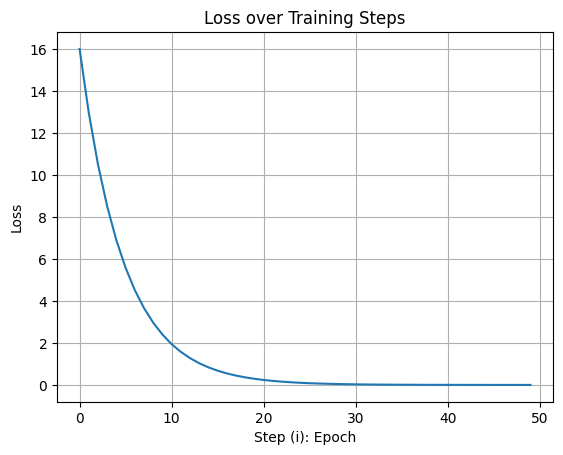

In [34]:
import matplotlib.pyplot as plt

# 'i'는 0부터 시작하여 len(loss_list)-1까지의 값을 가지므로, x축은 range(len(loss_list))로 설정합니다.
steps = range(len(loss_list))
# loss_list에서 각 Value 객체의 'data' 속성만 추출하여 플롯합니다.
plt.plot(steps, [l['data'] for l in loss_list])
plt.xlabel("Step (i): Epoch")
plt.ylabel("Loss")
plt.title("Loss over Training Steps")
plt.grid(True)
plt.show()

Value 클래스를 사용하여, 간단한 선형 회귀(Linear Regression) 모델을 학습시키는 과정
- $y = w \cdot x + b$라는 아주 단순한 식에서,
- 데이터 $(x=2.0, y=5.0)$가 주어졌을 때 정답에 가까워지도록 가중치 $w$와 편향 $b$를 업데이트하는 과정을 담고 있습니다.

In [35]:
import math

class Value:
    # 메모리 최적화: 인스턴스 변수를 고정하여 관리 (속도 향상 및 메모리 절감)
    # __slots__는 파이썬에서 메모리 사용량을 줄이고 속도를 높이기 위해 사용하는 특수 변수
    __slots__ = ('data', 'grad', '_children', '_local_grads')

    def __init__(self, data, children=(), local_grads=()):
        self.data = data                # 순전파(Forward) 시 계산된 실제 값 (스칼라)
        self.grad = 0                   # 역전파(Backward) 시 계산될 손실 함수에 대한 이 노드의 미분값
        self._children = children       # 이 노드를 만든 부모 노드들 (연산 그래프 추적용)
        self._local_grads = local_grads # 현재 연산에서 각 자식에 대한 국소 미분값 (로컬 그래디언트)

    # 더하기 연산 (a + b)
    def __add__(self, other):
        # 숫자가 들어오면 Value 객체로 변환
        other = other if isinstance(other, Value) else Value(other)
        # 결과값 계산 및 로컬 미분값 (1, 1) 저장 (x+y를 x로 미분하면 1, y로 미분하면 1)
        return Value(self.data + other.data, (self, other), (1, 1))

    # 곱하기 연산 (a * b)
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        # 로컬 미분값: x*y를 x로 미분하면 y, y로 미분하면 x
        return Value(self.data * other.data, (self, other), (other.data, self.data))

    # 거듭제곱 연산 (a ** n)
    def __pow__(self, other):
        # 로컬 미분값: x^n을 x로 미분하면 n * x^(n-1)
        return Value(self.data**other, (self,), (other * self.data**(other-1),))

    def log(self):
        # log(x)를 x로 미분하면 1/x
        return Value(math.log(self.data), (self,), (1/self.data,))

    def exp(self):
        # e^x를 x로 미분하면 e^x
        return Value(math.exp(self.data), (self,), (math.exp(self.data),))

    def relu(self):
        # ReLU 미분: x > 0 이면 1, 아니면 0
        return Value(max(0, self.data), (self,), (float(self.data > 0),))

    # --- 연산자 오버로딩 (편의 기능) ---
    def __neg__(self): return self * -1                # -self
    def __radd__(self, other): return self + other      # other + self
    def __sub__(self, other): return self + (-other)   # self - other
    def __rsub__(self, other): return other + (-self)  # other - self
    def __rmul__(self, other): return self * other      # other * self
    def __truediv__(self, other): return self * other**-1 # self / other
    def __rtruediv__(self, other): return other * self**-1 # other / self

    # 역전파(Backpropagation) 엔진
    def backward(self):
        topo = []      # 위상 정렬된 노드 리스트
        visited = set()

        # 1. 위상 정렬 (Topological Sort): 그래프를 끝에서부터 거꾸로 순회하기 위한 순서 정하기
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build_topo(child)
                topo.append(v) # 자식들을 먼저 다 방문한 후 자신을 추가

        build_topo(self)

        # 2. 미분 시작
        self.grad = 1 # 출력(Loss)에 대한 자기 자신의 미분값은 항상 1

        # 3. 체인 룰(Chain Rule) 적용: 정렬된 리스트를 역순으로 순회
        for v in reversed(topo):
            for child, local_grad in zip(v._children, v._local_grads):
                # 자식의 미분값 = (현재 노드의 미분값) * (현재 연산의 로컬 미분값)
                child.grad += local_grad * v.grad

In [39]:
w = Value(0.5)
print(w.data)
print(w.grad)
print(w._children) # 이 노드를 만든 부모 노드들 (연산 그래프 추적용)
print(w._local_grads) # 현재 연산에서 각 자식에 대한 국소 미분값 (로컬 그래디언트)

0.5
0
()
()


In [37]:
# 1. 초기 파라미터 설정 (w=0.5, b=0.0으로 시작)
w = Value(0.5); b = Value(0.0)

# 학습 데이터 (입력 2.0일 때 정답은 5.0이라고 가정)
x = 2.0
target = 5.0

pred_list = []
loss_list = []

# 학습 횟수 (Epochs)
for i in range(50):
    # --- [순전파 (Forward Pass)] ---
    # 예측값 계산: y = w * x + b
    pred = w * x + b
    pred_list.append(pred.data)
    # 손실 함수 계산: (예측값 - 정답)^2 (Mean Squared Error 방식)
    loss = (pred - target)**2
    loss_list.append(loss.data)

    # --- [역전파 (Backward Pass)] ---
    # 기존 미분값 초기화 (매 단계 새로 계산해야 함)
    w.grad = 0; b.grad = 0

    # 전체 그래프를 거슬러 올라가며 미분값(grad) 계산
    loss.backward()

    # --- [파라미터 업데이트 (Optimizer)] ---
    # 학습률(Learning Rate)을 곱해 미분 반대 방향으로 이동
    learning_rate = 0.01
    w.data -= learning_rate * w.grad
    b.data -= learning_rate * b.grad

    if i % 5 == 0:
        print(f"Step {i}: Loss = {loss.data:.4f}, Pred = {pred.data:.4f}")


print(f'pred_list: {pred_list}')
print(f'loss_list: {loss_list}')
print(f"\n최종 결과 -> w: {w.data:.2f}, b: {b.data:.2f}")
print(f"최종 예측값: {w.data * x + b.data:.2f} (정답 5.0에 근접!)")

Step 0: Loss = 16.0000, Pred = 1.0000
Step 5: Loss = 5.5789, Pred = 2.6380
Step 10: Loss = 1.9452, Pred = 3.6053
Step 15: Loss = 0.6783, Pred = 4.1764
Step 20: Loss = 0.2365, Pred = 4.5137
Step 25: Loss = 0.0825, Pred = 4.7128
Step 30: Loss = 0.0288, Pred = 4.8304
Step 35: Loss = 0.0100, Pred = 4.8999
Step 40: Loss = 0.0035, Pred = 4.9409
Step 45: Loss = 0.0012, Pred = 4.9651
pred_list: [1.0, 1.4000000000000001, 1.76, 2.084, 2.3756, 2.63804, 2.8742360000000002, 3.0868124000000003, 3.27813116, 3.4503180440000003, 3.6052862396000003, 3.74475761564, 3.8702818540760004, 3.9832536686684, 4.084928301801559, 4.176435471621404, 4.258791924459263, 4.332912732013337, 4.399621458812003, 4.459659312930802, 4.513693381637722, 4.56232404347395, 4.606091639126555, 4.6454824752139, 4.68093422769251, 4.712840804923259, 4.741556724430933, 4.767401051987839, 4.790660946789056, 4.81159485211015, 4.830435366899135, 4.847391830209221, 4.862652647188299, 4.876387382469469, 4.888748644222522, 4.89987377980027

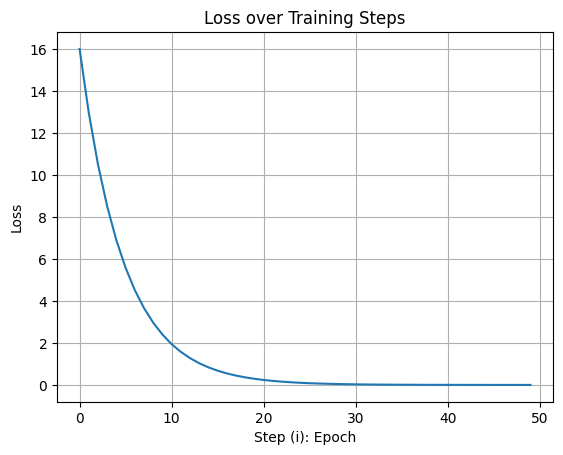

In [38]:
import matplotlib.pyplot as plt

# 'i'는 0부터 시작하여 len(loss_list)-1까지의 값을 가지므로, x축은 range(len(loss_list))로 설정합니다.
steps = range(len(loss_list))
plt.plot(steps, loss_list)
plt.xlabel("Step (i): Epoch")
plt.ylabel("Loss")
plt.title("Loss over Training Steps")
plt.grid(True)
plt.show()

### 모듈 4 ▲ GPT-2 유사 신경망 구조
### 4.1. 파라미터 초기화


In [44]:
# Initialize the parameters, to store the knowledge of the model

n_layer = 1      # 트랜스포머 레이어 수
n_embd = 16      # 임베딩 차원
block_size = 16  # 최대 컨텍스트 길이
n_head = 4       # 멀티헤드 어텐션의 헤드 수
head_dim = n_embd // n_head  # 헤드당 차원 = 4
matrix = lambda nout, nin, std=0.08: [[Value(random.gauss(0, std)) for _ in range(nin)] for _ in range(nout)]
state_dict = {'wte': matrix(vocab_size, n_embd), 'wpe': matrix(block_size, n_embd), 'lm_head': matrix(vocab_size, n_embd)}

### 4.2. 전체 신경망 흐름 (gpt 함수)
- Transformer Language Model Architecture

 1️⃣ Input Stage

$$
\text{Token ID} + \text{Position ID}
$$

↓

Embedding Layer

$$
\mathbf{X} = \text{wte}(\text{Token}) + \text{wpe}(\text{Position})
$$

- **wte**: Token Embedding  
- **wpe**: Position Embedding  

↓

RMS Normalization

$$
\mathbf{X}_{norm} = \text{RMSNorm}(\mathbf{X})
$$

---

2️⃣ Transformer Block (Repeated L times)

For each layer:

(1) RMSNorm

$$
\mathbf{H}_1 = \text{RMSNorm}(\mathbf{X})
$$

---

(2) Multi-Head Self-Attention

Query, Key, Value 계산:

$$
Q = \mathbf{H}_1 W_Q
$$
$$
K = \mathbf{H}_1 W_K
$$
$$
V = \mathbf{H}_1 W_V
$$

Scaled Dot-Product Attention:

$$
\text{Attention}(Q,K,V) =
\text{Softmax}\left(
\frac{QK^T}{\sqrt{d_k}}
\right)V
$$

Multi-head 결합:

$$
\text{MHA} = \text{Concat}(\text{head}_1, ..., \text{head}_h) W_O
$$

---

(3) Residual Connection

$$
\mathbf{X}_1 = \mathbf{X} + \text{MHA}
$$

---

(4) RMSNorm

$$
\mathbf{H}_2 = \text{RMSNorm}(\mathbf{X}_1)
$$

---
(5) MLP (Feed Forward Network)

$$
\mathbf{F} = \text{FC}_2(\text{ReLU}(\text{FC}_1(\mathbf{H}_2)))
$$

---
(6) Residual Connection

$$
\mathbf{X}_{next} = \mathbf{X}_1 + \mathbf{F}
$$

---

3️⃣ Output Layer

Language Modeling Head

$$
\text{logits} = \mathbf{X}_{final} W_{lm}
$$

↓

Next Token Probability

$$
P(\text{token}) = \text{Softmax}(\text{logits})
$$


토큰 ID + 위치 ID

    ↓
[wte] 토큰 임베딩 + [wpe] 위치 임베딩

    ↓
RMSNorm 정규화
    ↓

[ 트랜스포머 레이어 반복 ]
-  ├─ RMSNorm
-  ├─ Multi-Head Self-Attention (Q, K, V 계산 → 소프트맥스 → 가중합)
-  ├─ 잔차 연결(Residual)
-  ├─ RMSNorm
-  ├─ MLP (FC1 → ReLU → FC2)
-  └─ 잔차 연결

    ↓
[lm_head] 선형 변환 → 로짓(logits)

### 4.3. 핵심 구성요소 설명
**a. 임베딩 (Embedding)**
- 토큰 의미 + 위치 정보를 동시에 인코딩합니다.


In [45]:
tok_emb = state_dict['wte'][token_id]  # 토큰 → 16차원 벡터
pos_emb = state_dict['wpe'][pos_id]    # 위치 → 16차원 벡터
x = [t + p for t, p in zip(tok_emb, pos_emb)]  # 합산

NameError: name 'token_id' is not defined

**b. RMSNorm (Root Mean Square Normalization)**
- 학습을 안정화하는 정규화입니다. GPT-2의 LayerNorm을 단순화한 버전입니다.


In [ ]:
def rmsnorm(x):
    ms = sum(xi * xi for xi in x) / len(x)
    scale = (ms + 1e-5) ** -0.5
    return [xi * scale for xi in x]

**c. Multi-Head Self-Attention**


In [ ]:
q = linear(x, attn_wq)   # Query: "무엇을 찾고 있나?"
k = linear(x, attn_wk)   # Key:   "나는 이런 정보다"
v = linear(x, attn_wv)   # Value: "실제로 전달할 내용"

# 어텐션 스코어 = Q·K / √head_dim
# attn_weights = softmax(scores)
# output = Σ(attn_weights × V)

NameError: name 'attn_wq' is not defined

### 4.1.

In [ ]:
"""
The most atomic way to train and run inference for a GPT in pure, dependency-free Python.
This file is the complete algorithm.
Everything else is just efficiency.

@karpathy
"""

import os       # os.path.exists
import math     # math.log, math.exp
import random   # random.seed, random.choices, random.gauss, random.shuffle
random.seed(42) # Let there be order among chaos

# Let there be a Dataset `docs`: list[str] of documents (e.g. a list of names)
if not os.path.exists('input.txt'):
    import urllib.request
    names_url = 'https://raw.githubusercontent.com/karpathy/makemore/988aa59/names.txt'
    urllib.request.urlretrieve(names_url, 'input.txt')
docs = [line.strip() for line in open('input.txt') if line.strip()]
random.shuffle(docs)
docs = docs[:3200]
print(f"num docs: {len(docs)}")

# Let there be a Tokenizer to translate strings to sequences of integers ("tokens") and back
uchars = sorted(set(''.join(docs))) # unique characters in the dataset become token ids 0..n-1
BOS = len(uchars) # token id for a special Beginning of Sequence (BOS) token
vocab_size = len(uchars) + 1 # total number of unique tokens, +1 is for BOS
print(f"vocab size: {vocab_size}")

# Let there be Autograd to recursively apply the chain rule through a computation graph
class Value:
    __slots__ = ('data', 'grad', '_children', '_local_grads') # Python optimization for memory usage

    def __init__(self, data, children=(), local_grads=()):
        self.data = data                # scalar value of this node calculated during forward pass
        self.grad = 0                   # derivative of the loss w.r.t. this node, calculated in backward pass
        self._children = children       # children of this node in the computation graph
        self._local_grads = local_grads # local derivative of this node w.r.t. its children

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.data + other.data, (self, other), (1, 1))

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.data * other.data, (self, other), (other.data, self.data))

    def __pow__(self, other): return Value(self.data**other, (self,), (other * self.data**(other-1),))
    def log(self): return Value(math.log(self.data), (self,), (1/self.data,))
    def exp(self): return Value(math.exp(self.data), (self,), (math.exp(self.data),))
    def relu(self): return Value(max(0, self.data), (self,), (float(self.data > 0),))
    def __neg__(self): return self * -1
    def __radd__(self, other): return self + other
    def __sub__(self, other): return self + (-other)
    def __rsub__(self, other): return other + (-self)
    def __rmul__(self, other): return self * other
    def __truediv__(self, other): return self * other**-1
    def __rtruediv__(self, other): return other * self**-1

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            for child, local_grad in zip(v._children, v._local_grads):
                child.grad += local_grad * v.grad

# Initialize the parameters, to store the knowledge of the model
n_layer = 1     # depth of the transformer neural network (number of layers)
n_embd = 16     # width of the network (embedding dimension)
block_size = 16 # maximum context length of the attention window (note: the longest name is 15 characters)
n_head = 4      # number of attention heads
head_dim = n_embd // n_head # derived dimension of each head
matrix = lambda nout, nin, std=0.08: [[Value(random.gauss(0, std)) for _ in range(nin)] for _ in range(nout)]
state_dict = {'wte': matrix(vocab_size, n_embd), 'wpe': matrix(block_size, n_embd), 'lm_head': matrix(vocab_size, n_embd)}
for i in range(n_layer):
    state_dict[f'layer{i}.attn_wq'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.attn_wk'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.attn_wv'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.attn_wo'] = matrix(n_embd, n_embd)
    state_dict[f'layer{i}.mlp_fc1'] = matrix(4 * n_embd, n_embd)
    state_dict[f'layer{i}.mlp_fc2'] = matrix(n_embd, 4 * n_embd)
params = [p for mat in state_dict.values() for row in mat for p in row] # flatten params into a single list[Value]
print(f"num params: {len(params)}")

# Define the model architecture: a function mapping tokens and parameters to logits over what comes next
# Follow GPT-2, blessed among the GPTs, with minor differences: layernorm -> rmsnorm, no biases, GeLU -> ReLU
def linear(x, w):
    return [sum(wi * xi for wi, xi in zip(wo, x)) for wo in w]

def softmax(logits):
    max_val = max(val.data for val in logits)
    exps = [(val - max_val).exp() for val in logits]
    total = sum(exps)
    return [e / total for e in exps]

def rmsnorm(x):
    ms = sum(xi * xi for xi in x) / len(x)
    scale = (ms + 1e-5) ** -0.5
    return [xi * scale for xi in x]

def gpt(token_id, pos_id, keys, values):
    tok_emb = state_dict['wte'][token_id] # token embedding
    pos_emb = state_dict['wpe'][pos_id] # position embedding
    x = [t + p for t, p in zip(tok_emb, pos_emb)] # joint token and position embedding
    x = rmsnorm(x) # note: not redundant due to backward pass via the residual connection

    for li in range(n_layer):
        # 1) Multi-head Attention block
        x_residual = x
        x = rmsnorm(x)
        q = linear(x, state_dict[f'layer{li}.attn_wq'])
        k = linear(x, state_dict[f'layer{li}.attn_wk'])
        v = linear(x, state_dict[f'layer{li}.attn_wv'])
        keys[li].append(k)
        values[li].append(v)
        x_attn = []
        for h in range(n_head):
            hs = h * head_dim
            q_h = q[hs:hs+head_dim]
            k_h = [ki[hs:hs+head_dim] for ki in keys[li]]
            v_h = [vi[hs:hs+head_dim] for vi in values[li]]
            attn_logits = [sum(q_h[j] * k_h[t][j] for j in range(head_dim)) / head_dim**0.5 for t in range(len(k_h))]
            attn_weights = softmax(attn_logits)
            head_out = [sum(attn_weights[t] * v_h[t][j] for t in range(len(v_h))) for j in range(head_dim)]
            x_attn.extend(head_out)
        x = linear(x_attn, state_dict[f'layer{li}.attn_wo'])
        x = [a + b for a, b in zip(x, x_residual)]
        # 2) MLP block
        x_residual = x
        x = rmsnorm(x)
        x = linear(x, state_dict[f'layer{li}.mlp_fc1'])
        x = [xi.relu() for xi in x]
        x = linear(x, state_dict[f'layer{li}.mlp_fc2'])
        x = [a + b for a, b in zip(x, x_residual)]

    logits = linear(x, state_dict['lm_head'])
    return logits

# Let there be Adam, the blessed optimizer and its buffers
learning_rate, beta1, beta2, eps_adam = 0.01, 0.85, 0.99, 1e-8
m = [0.0] * len(params) # first moment buffer
v = [0.0] * len(params) # second moment buffer

# Repeat in sequence
num_steps = 1000 # number of training steps
for step in range(num_steps):

    # Take single document, tokenize it, surround it with BOS special token on both sides
    doc = docs[step % len(docs)]
    tokens = [BOS] + [uchars.index(ch) for ch in doc] + [BOS]
    n = min(block_size, len(tokens) - 1)

    # Forward the token sequence through the model, building up the computation graph all the way to the loss
    keys, values = [[] for _ in range(n_layer)], [[] for _ in range(n_layer)]
    losses = []
    for pos_id in range(n):
        token_id, target_id = tokens[pos_id], tokens[pos_id + 1]
        logits = gpt(token_id, pos_id, keys, values)
        probs = softmax(logits)
        loss_t = -probs[target_id].log()
        losses.append(loss_t)
    loss = (1 / n) * sum(losses) # final average loss over the document sequence. May yours be low.

    # Backward the loss, calculating the gradients with respect to all model parameters
    loss.backward()

    # Adam optimizer update: update the model parameters based on the corresponding gradients
    lr_t = learning_rate * (1 - step / num_steps) # linear learning rate decay
    for i, p in enumerate(params):
        m[i] = beta1 * m[i] + (1 - beta1) * p.grad
        v[i] = beta2 * v[i] + (1 - beta2) * p.grad ** 2
        m_hat = m[i] / (1 - beta1 ** (step + 1))
        v_hat = v[i] / (1 - beta2 ** (step + 1))
        p.data -= lr_t * m_hat / (v_hat ** 0.5 + eps_adam)
        p.grad = 0

    print(f"step {step+1:4d} / {num_steps:4d} | loss {loss.data:.4f}", end='\r')

# Inference: may the model babble back to us
temperature = 0.5 # in (0, 1], control the "creativity" of generated text, low to high
print("\n--- inference (new, hallucinated names) ---")
for sample_idx in range(20):
    keys, values = [[] for _ in range(n_layer)], [[] for _ in range(n_layer)]
    token_id = BOS
    sample = []
    for pos_id in range(block_size):
        logits = gpt(token_id, pos_id, keys, values)
        probs = softmax([l / temperature for l in logits])
        token_id = random.choices(range(vocab_size), weights=[p.data for p in probs])[0]
        if token_id == BOS:
            break
        sample.append(uchars[token_id])
    print(f"sample {sample_idx+1:2d}: {''.join(sample)}")

num docs: 3200
vocab size: 27
num params: 4192
step 1000 / 1000 | loss 2.6497
--- inference (new, hallucinated names) ---
sample  1: kamon
sample  2: ann
sample  3: karai
sample  4: jaire
sample  5: vialan
sample  6: karia
sample  7: yeran
sample  8: anna
sample  9: areli
sample 10: kaina
sample 11: konna
sample 12: keylen
sample 13: liole
sample 14: alerin
sample 15: earan
sample 16: lenne
sample 17: kana
sample 18: lara
sample 19: alela
sample 20: anton


Andrej Karpathy의 minGPT 혹은 micrograd 스타일의 교육용 코드입니다. 직접 구현한 Value 클래스와 수동 연산들을 PyTorch의 핵심 기능인 torch.Tensor와 nn.Module 등을 사용하여 간략하게 리팩토링해 보겠습니다.

PyTorch를 사용하면 수동으로 구현했던 Autograd(역전파), Layer 구성, Adam 옵티마이저를 단 몇 줄로 줄일 수 있습니다.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import os, urllib.request, random

# 1. 데이터 준비 (기존과 동일)
if not os.path.exists('input.txt'):
    names_url = 'https://raw.githubusercontent.com/karpathy/makemore/988aa59/names.txt'
    urllib.request.urlretrieve(names_url, 'input.txt')
docs = [line.strip() for line in open('input.txt') if line.strip()]
random.seed(42); random.shuffle(docs)
# docs = docs[:3200]

uchars = sorted(set(''.join(docs)))
vocab_size = len(uchars) + 1
BOS = len(uchars)
char_to_it = {ch: i for i, ch in enumerate(uchars)}
it_to_char = {i: ch for i, ch in enumerate(uchars)}

# 2. 하이퍼파라미터
n_layer, n_embd, block_size, n_head = 1, 16, 16, 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 3. GPT 모델 정의 (PyTorch Module 활용)
class SimpleGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, n_embd)
        self.wpe = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[
            nn.TransformerEncoderLayer(d_model=n_embd, nhead=n_head, dim_feedforward=4*n_embd,
                                       activation='relu', batch_first=True, norm_first=True)
            for _ in range(n_layer)
        ])
        self.ln_f = nn.RMSNorm(n_embd) # PyTorch 최신 버전 기준
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

    def forward(self, idx):
        b, t = idx.size()
        pos = torch.arange(0, t, device=device).unsqueeze(0)
        x = self.wte(idx) + self.wpe(pos)

        # 인과적 마스킹(Causal Mask) 적용
        mask = torch.triu(torch.ones(t, t, device=device) * float('-inf'), diagonal=1)
        x = self.blocks[0].self_attn(x, x, x, attn_mask=mask)[0] + x # 단순화를 위해 레이어 직접 호출
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits

model = SimpleGPT().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.85, 0.99))

# 4. 학습 루프
for step in range(1000):
    doc = docs[step % len(docs)]
    tokens = [BOS] + [char_to_it[ch] for ch in doc] + [BOS]
    x_idx = torch.tensor([tokens[:-1]], device=device)
    y_idx = torch.tensor([tokens[1:]], device=device)

    logits = model(x_idx)
    loss = F.cross_entropy(logits.view(-1, vocab_size), y_idx.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"step {step} | loss {loss.item():.4f}")

# 5. 추론 (Inference)
print("\n--- 생성된 이름 ---")
model.eval()
with torch.no_grad():
    for _ in range(10):
        out = []
        idx = torch.tensor([[BOS]], device=device)
        for _ in range(block_size):
            logits = model(idx)[:, -1, :] / 0.5
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            if next_id.item() == BOS: break
            out.append(it_to_char[next_id.item()])
            idx = torch.cat((idx, next_id), dim=1)
        print("".join(out))

step 0 | loss 3.5359
step 100 | loss 2.5243
step 200 | loss 2.2194
step 300 | loss 2.6814
step 400 | loss 2.5972
step 500 | loss 2.4916
step 600 | loss 2.2032
step 700 | loss 2.3732
step 800 | loss 2.2603
step 900 | loss 2.0710

--- 생성된 이름 ---
jerel
nariy
canera
solalin
anon
monne
lii
shona
nerela
lleen
